In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

In [2]:
# Load the dataset
df = pd.read_csv("SHB.VN.csv")
df

,Date,Open,High,Low,Close,Volume
0,15/01/2019,3510240967,3610533447,3460094727,3560387207,7846433
1,16/01/2019,3560387207,3610533447,3510240967,3510240967,4101711
2,17/01/2019,3560387207,3560387207,3510240967,3510240967,4372021
3,18/01/2019,3560387207,3560387207,3510240967,3510240967,5207458
4,21/01/2019,3510240967,3660679932,3510240967,3610533447,15705724
...,...,...,...,...,...,...
1274,8/3/2024,11950000000,12000000000,11700000000,11700000000,26237800
1275,11/3/2024,11700000000,11700000000,11350000000,11400000000,40610500
1276,12/3/2024,11350000000,11450000000,11250000000,11300000000,27009840
1277,13/03/2024,11300000000,11600000000,11300000000,11550000000,18066700


In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df = df.set_index(pd.DatetimeIndex(df['Date'].values))

# Create new dataframe with Date and Close
df = pd.DataFrame(df, columns=['Close'])


<ipython-input-3-84f009dfe440>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [5]:
# n_in : 5  : Observation in the past
n_in = 5
# n_out: 1: Predict in the future
n_out = 1
values = df.values
data_supervised = series_to_supervised(values, n_in, n_out)


In [12]:
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size

# Get Data
train_data = data_supervised[:train_size]
test_data = data_supervised[train_size:]

# Make input
X_train, y_train = train_data[:, :-n_out], train_data[:, -n_out:]
X_test, y_test = test_data[:, :-n_out], test_data[:, -n_out:]

In [13]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(objective='regression',
                      n_estimators=1000,
                      metric='l2',  # Metric for early stopping (similar to squared error)
                      early_stopping_rounds=10)


In [14]:
# Training model
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='accuracy')

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1177
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 5
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score 10023340588.621229
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 8.11144e+16


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:300: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


LGBMRegressor(early_stopping_rounds=10, metric='l2', n_estimators=1000,
              objective='regression')

In [15]:
y_pred = model.predict(X_test)
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_pred, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, y_test)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.021902111293220797
RMSE on Test dataset:  284805929.10124683
MSLE on Test dataset:  0.0008547966436192179


In [16]:
last_date = df.index.max()
future_features = data_supervised[-1, :-n_out].reshape(1, -1)
prediction_next30_days = []

for _ in range(30):
    y_pred_next_day = model.predict(future_features)
    prediction_next30_days.append(y_pred_next_day[0])

    # Update future_features
    future_features = np.roll(future_features, -1, axis=1)
    future_features[0, -1] = y_pred_next_day[0]

future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

# Predict 60 days
prediction_next60_days = []
for _ in range(60):
    y_pred_next_day = model.predict(future_features)
    prediction_next60_days.append(y_pred_next_day[0])

    # Update future_features
    future_features = np.roll(future_features, -1, axis=1)
    future_features[0, -1] = y_pred_next_day[0]

future_dates_60 = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=60, freq='D')

# Predict 90 days
prediction_next90_days = []
for _ in range(90):
    y_pred_next_day = model.predict(future_features)
    prediction_next90_days.append(y_pred_next_day[0])

    # Update future_features
    future_features = np.roll(future_features, -1, axis=1)
    future_features[0, -1] = y_pred_next_day[0]

future_dates_90 = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=90, freq='D')

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:599: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


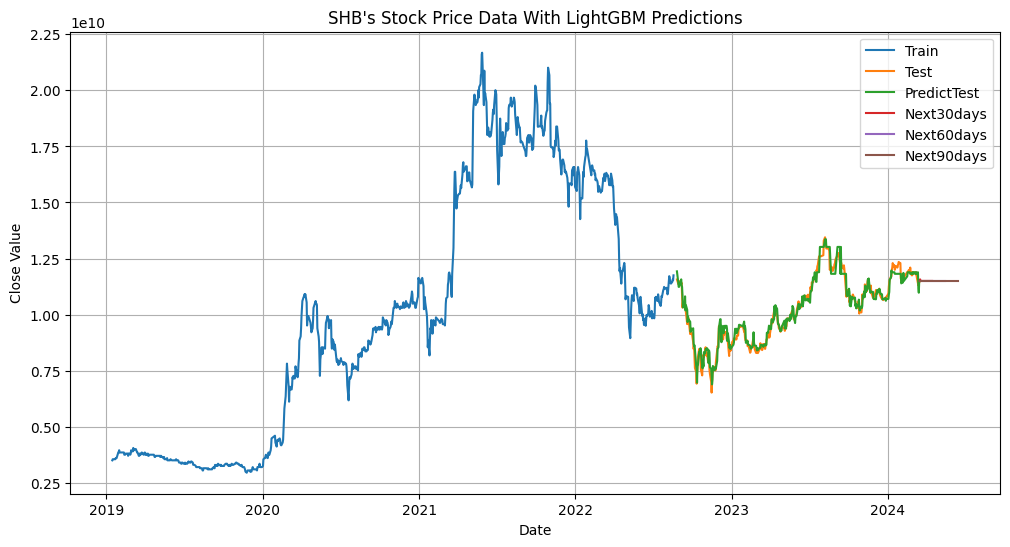

In [17]:
plt.figure(figsize=(12,6))

plt.plot(df.index[:train_size], y_train)

plt.plot(df.index[train_size + n_in:], y_test)

plt.plot(df.index[train_size + n_in:], y_pred)

plt.plot(future_dates, prediction_next30_days)
plt.plot(future_dates_60, prediction_next60_days)
plt.plot(future_dates_90, prediction_next90_days)

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title("SHB's Stock Price Data With LightGBM Predictions")
plt.legend(['Train','Test', 'PredictTest','Next30days', 'Next60days', 'Next90days'])
plt.grid()